In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from pathlib import Path
import urllib

import numpy as np
import tensorflow as tf
#tf.enable_eager_execution()

from pycocotools import coco
import tqdm
from PIL import Image

import sys
sys.path.append("../../../")
import maskflow

import coco_utils

root_dir = Path("/home/hadim/.data/Neural_Network/Maskflow/COCO")

data_dir = root_dir / "Data"
data_dir.mkdir(parents=True, exist_ok=True)

annotations_dir = data_dir / "annotations"

params = maskflow.load_parameters("parameters.yml")
class_names = params["CLASS_NAMES"]

# Copy config next to data folder
maskflow.save_parameters(params, root_dir / "parameters.yml")

if not annotations_dir.is_dir():
    coco_utils.download_cocodataset(data_dir)

## Define dataset to build

In [14]:
coco_set = "val"
coco_year = 2017

tfrecord_path = data_dir / "evaluation_data.tfrecord"

max_image = 200

## Build the dataset

(Can be long...)

In [15]:
annotations_path = annotations_dir / f"instances_{coco_set}{coco_year}.json"
coco_data = coco.COCO(annotation_file=str(annotations_path))

class_names = [value["name"] for _, value in coco_data.cats.items()]
params["CLASS_NAMES"] = class_names
maskflow.save_parameters(params, "parameters.yml")
maskflow.save_parameters(params, root_dir / "parameters.yml")

tfrecord_writer = tf.python_io.TFRecordWriter(str(tfrecord_path))

n = len(coco_data.imgs)
for i, image_id in enumerate(tqdm.tqdm(coco_data.getImgIds()[:max_image], total=max_image)):
    
    image_info = coco_data.loadImgs(ids=[image_id])[0]
    
    # Download image
    image = Image.open(urllib.request.urlopen(image_info["coco_url"]))
    image = np.array(image)
    
    anns = coco_data.imgToAnns[image_id]
    
    class_ids = []
    masks = []

    for ann in anns:
        # Get class id
        class_name = coco_data.loadCats(ids=[ann["category_id"]])[0]["name"]
        class_id = class_names.index(class_name) + 1
        class_ids.append(class_id)

        # Get mask
        mask = coco_data.annToMask(ann)
        assert mask.shape == image.shape[:2]
        masks.append(mask)

    class_ids = np.array(class_ids)
    masks = np.array(masks)
    
    tf_example = maskflow.create_tf_example(i, image_info["file_name"], image, masks, class_ids)
    tfrecord_writer.write(tf_example.SerializeToString())
    
tfrecord_writer.close()

loading annotations into memory...
Done (t=0.44s)
creating index...
index created!


100%|██████████| 200/200 [01:46<00:00,  1.88it/s]


## Visualize some images with annotations

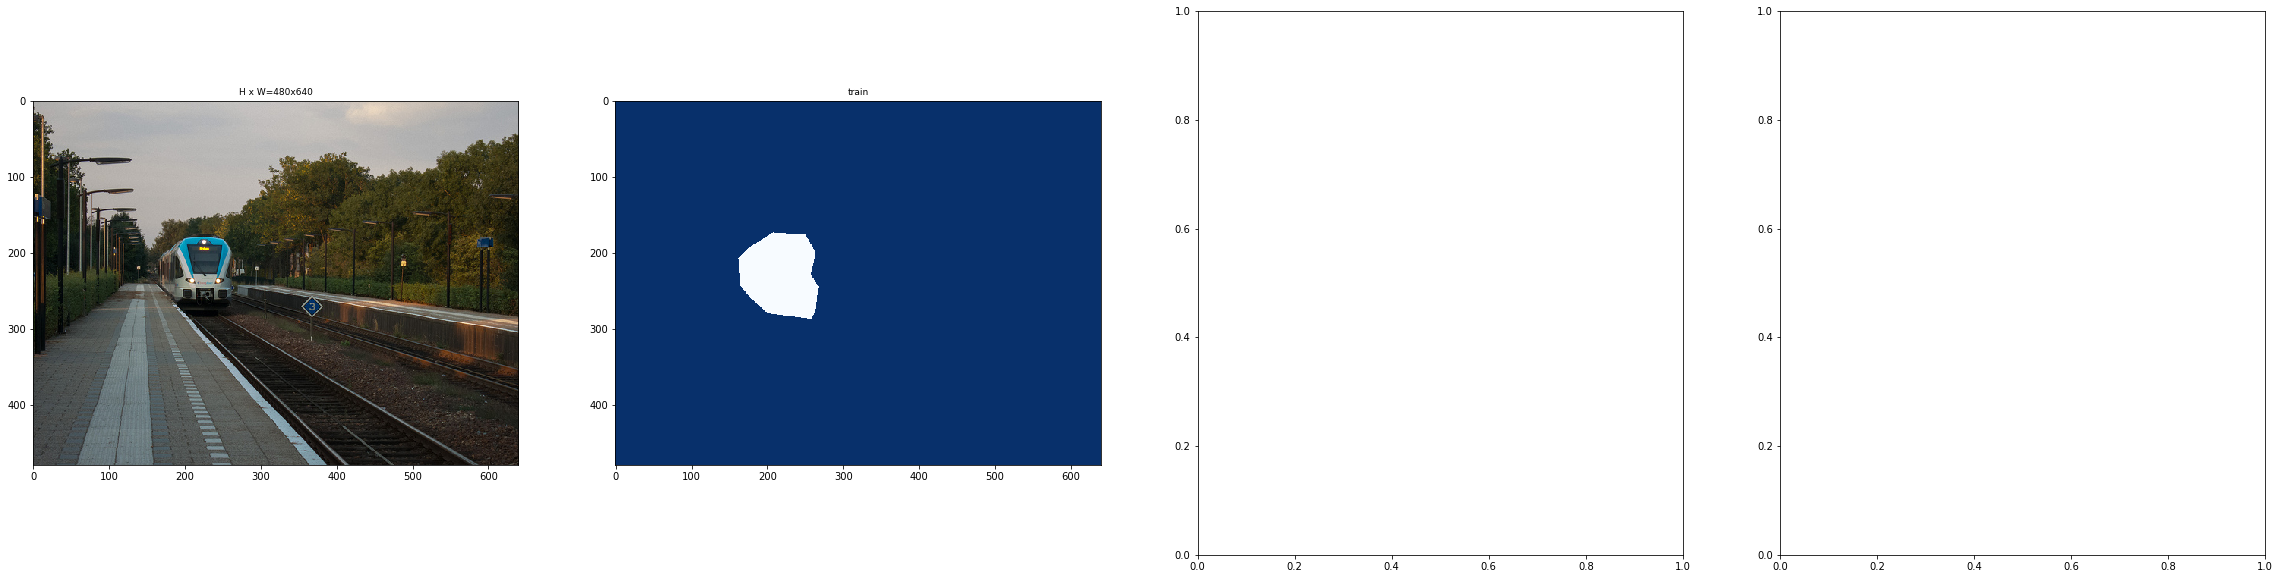

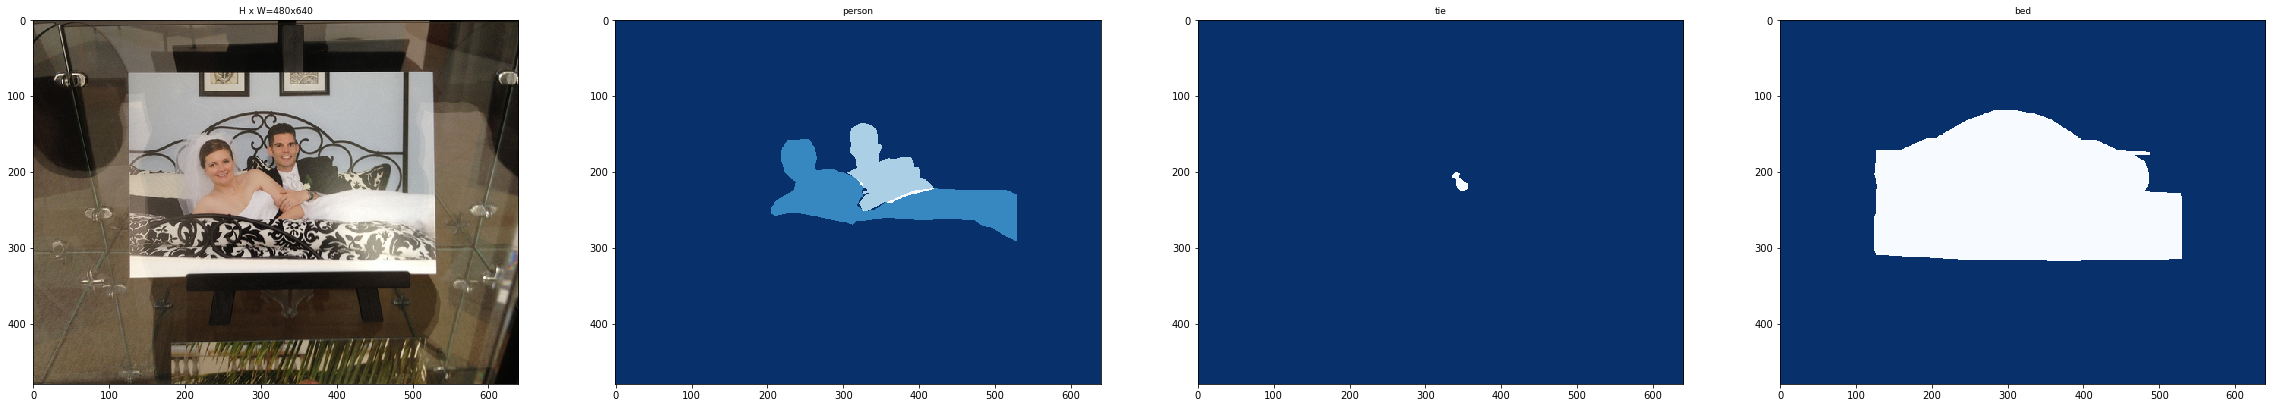

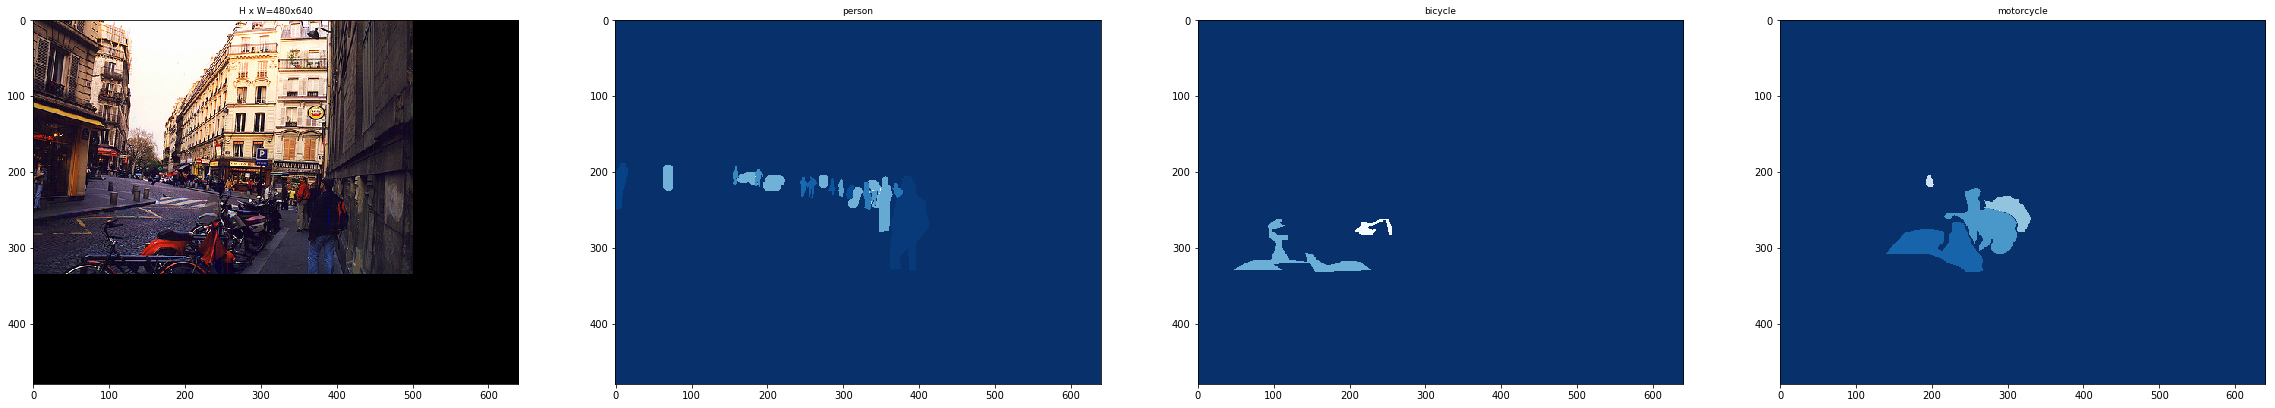

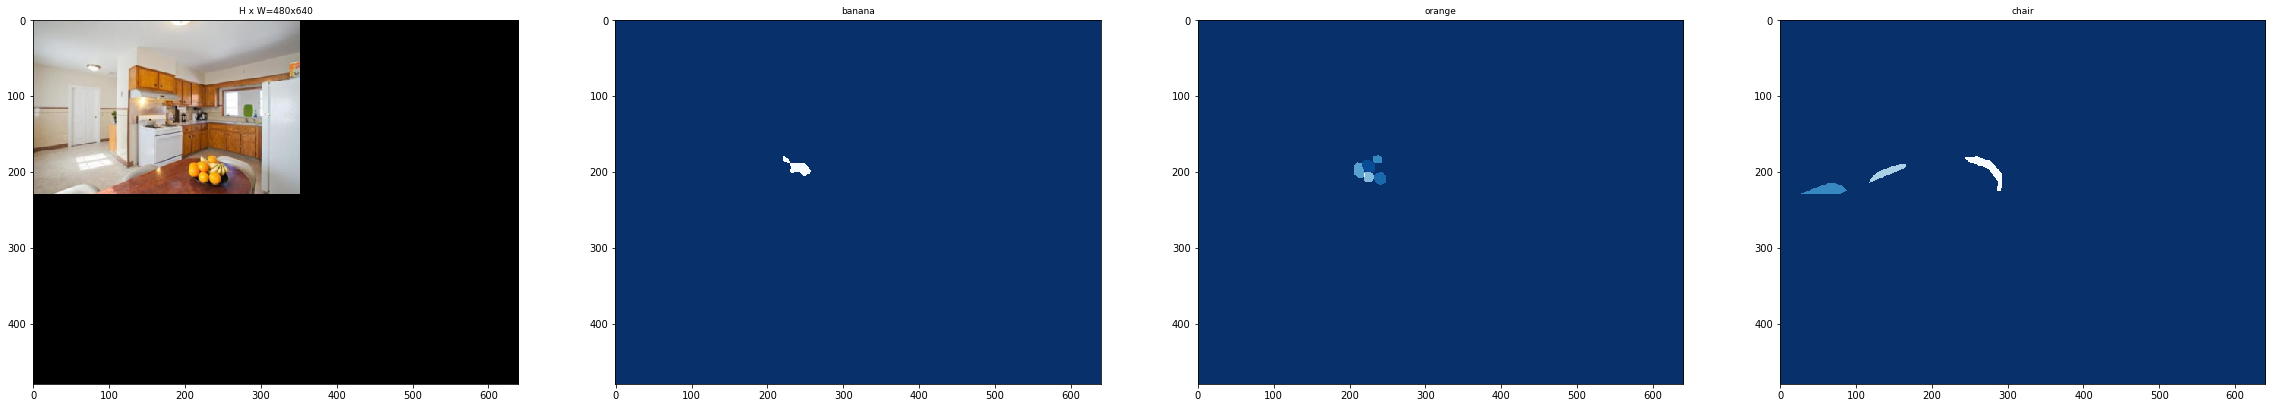

In [21]:
# Retrieve some data
images, annotations = maskflow.get_data(tfrecord_path, n=4, shuffle=True)

# Display them
maskflow.batch_display_top_masks(images, annotations["masks"], annotations["class_ids"], params["CLASS_NAMES"],
                                 limit=3, basesize=40)